# Homework 5

## The goal of this assignment is to build a very simple model to model the relationship, if any, between the incidence level of colon and rectum cancer for each county and the income level for that county.

1. How you prepared the data for modeling
2. What features you used and how they were computed.
3. The model that you built to model the relationship, if any. 
4. How you evaluated the model.

In [156]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from numpy import arange

%matplotlib inline

In [73]:
# Loading the colon/rectum incidence level data
incidence = pd.read_csv('./incd-v3.txt', sep = '\t')
incidence = incidence.drop(0, axis=0).replace(to_replace = r"\(.*\)", value="", regex=True)
incidence = incidence.reset_index(drop=True)[['County', 'Age-Adjusted Incidence Rate - cases per 100,000', 'Recent 5-Year Trend in Incidence Rates']]
incidence.head()

,County,"Age-Adjusted Incidence Rate - cases per 100,000",Recent 5-Year Trend in Incidence Rates
0,"Yukon-Koyukuk Census Area, Alaska",138.6,2.9
1,"Union County, Florida",121.7,1.2
2,"Kingsbury County, South Dakota",114.2,2.2
3,"Wade Hampton Census Area, Alaska",102.1,*
4,"Nome Census Area, Alaska",101.2,2.6


In [74]:
# Loading the county level income level data
county = pd.read_csv('./census.csv', skiprows=6, skipfooter=11).drop(0, axis=0).reset_index(drop=True)[['State', 'Value (Dollars)']].rename(columns ={'State': 'County'})
county.head()

/Users/justina/anaconda3/envs/proj/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,County,Value (Dollars)
0,"Jefferson County, Mississippi",21816.000000000
1,"Todd County, South Dakota",22889.000000000
2,Puerto Rico,24391.000000000
3,"Holmes County, Mississippi",26374.000000000
4,"Clay County, Georgia",27500.000000000


In [75]:
print(f"Shape of Median Family Income data: {county.shape}")
print(f"Shape of Incidence data: {incidence.shape}")

Shape of Median Family Income data: (3141, 2)
Shape of Incidence data: (2948, 3)


In [91]:
data = incidence.merge(county, on = 'County')

In [92]:
# Join the incidence and income data on County
data = incidence.merge(county, on = 'County')
data = data.replace(to_replace = r"\s{0,2}\*{1,3}\s{0,2}", value = float('NaN'), regex=True).dropna(subset= ['Age-Adjusted Incidence Rate - cases per 100,000'])
data = data[data['Value (Dollars)']!='data not available']
data = data.astype({'Age-Adjusted Incidence Rate - cases per 100,000': 'float', 'Value (Dollars)': 'float'})
data.head()

data2 = data.dropna(how='any')

In [85]:

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
    # fut the model on all data
    model.fit(X, y)
    # plot the dataset
    plt.scatter(X, y)
    # plot the line of best fit
    xaxis = arange(X.min(), X.max(), 0.01)
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
    plt.plot(xaxis, yaxis, color='r')
    # show the plot
    plt.title(type(model).__name__)
    plt.show()

R^2: 0.1222278990850818


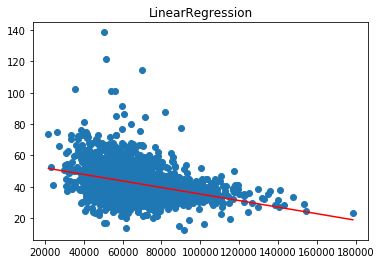

In [170]:
# Linear regression between Value and Age-adjusted incidence
from sklearn.linear_model import LinearRegression
X = data['Value (Dollars)'].to_numpy().reshape(-1,1)
y = data['Age-Adjusted Incidence Rate - cases per 100,000']
reg = LinearRegression().fit(data['Value (Dollars)'].to_numpy().reshape(-1,1), data['Age-Adjusted Incidence Rate - cases per 100,000'])
print(f'R^2: {reg.score(X, y)}')
plot_best_fit(X,y,reg)

R^2: 0.013715909788218572


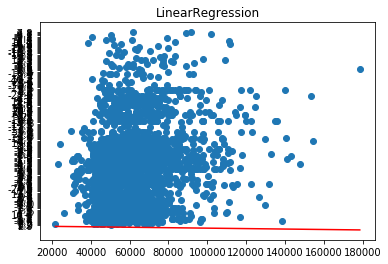

In [171]:
# Linear regression between Value and Recent 5-year trend in incidence
from sklearn.linear_model import LinearRegression
X = data2['Value (Dollars)'].to_numpy().reshape(-1,1)
y = data2['Recent 5-Year Trend in Incidence Rates']
reg = LinearRegression().fit(data2['Value (Dollars)'].to_numpy().reshape(-1,1), data2['Recent 5-Year Trend in Incidence Rates'])
print(f'R^2: {reg.score(X, y)}')
plot_best_fit(X,y,reg)

## Summary:

I cleaned both the incidence and income data so that low values (marked by \*) and NaN values are removed. Then I kept potentially relevant columns such as `'Age-Adjusted Incidence Rate - cases per 100,000'`, `'Recent 5-Year Trend in Incidence Rates'`, and `'Value (Dollars)'`. The two dataframes were joined on county to result in the final merged data `data`. I'm interested in determining whether there is a relationship between incidence and income so I do a simple linear regression first between `'Age-Adjusted Incidence Rate - cases per 100,000'` as `y` and `'Value (Dollars)'` as `X`. I evaluate the model based on the `R^2` given by the `model.score(X,y)` function. `R^2` gives the goodness-of-fit. The `R^2` between `'Age-Adjusted Incidence Rate - cases per 100,000'` and `'Value (Dollars)'` is **0.1222** and the `R^2` between `'Recent 5-Year Trend in Incidence Rates'`, and `'Value (Dollars)'` is **0.0137**, close to no association. `'Age-Adjusted Incidence Rate - cases per 100,000'` and `'Value (Dollars)'` model has a small positive linear association. Below I try to experiment with different polynomial features of the `'Value (Dollars)'` data to investigate whether higher polynomial features associate better with the income. I found that when the feature `'Value (Dollars)'` is transformed to a higher polynomial feature space, specifically of degree 3, the `R^2` value increases to **0.1307**; however, the association is still small.

Best R^2 score with polynomial features of degree 3.
Score is 0.13073825068399147.


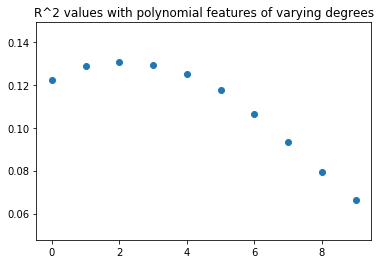

In [168]:
# Exploring polynomial features
from sklearn.preprocessing import PolynomialFeatures

X = data['Value (Dollars)'].to_numpy().reshape(-1,1)
y = data['Age-Adjusted Incidence Rate - cases per 100,000']
scores = []
for p in range(10):
    
    poly = PolynomialFeatures(p+1)
    X_poly = poly.fit_transform(X)
    reg = LinearRegression().fit(X_poly,y)
    scores.append(reg.score(X_poly, y))
plt.scatter(list(range(10)), scores)
plt.title('R^2 values with polynomial features of varying degrees')
print(f'Best R^2 score with polynomial features of degree {np.argmax(scores)+1}.')

poly = PolynomialFeatures(np.argmax(scores)+1)
X_poly = poly.fit_transform(X)
reg = LinearRegression().fit(X_poly,y)
print(f'Score is {reg.score(X_poly, y)}.')